In [6]:
import pandas as pd
import re
from tqdm.notebook import tqdm as tqdm_notebook
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
from itertools import combinations
import itertools
import csv

%matplotlib inline
pd.set_option('display.max_colwidth', None)

In [7]:
df = pd.read_csv('tickets_2.csv',
                 sep=';',
                 encoding='windows-1251')


In [8]:
df.head()

,start_dt,end_dt,sender_name,sender_email,theme,descr
0,2023-01-01 08:22:15+00,2023-01-01 19:14:50+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20595877,". Доброго времени суток! ПРОСЬБА ПРИ ОТВЕТЕ НА ЗАПРОС ИСПОЛЬЗЬЗОВАТЬ ФУНКЦИЮ ""ОТВЕТИТЬ ВСЕМ"" У абонента всплывает SIM-меню и блокирует работу телефона. Просьба отключить функционал сим-ремандера на апплете сим-карты. 0. Номер абонента : 79629002669 1. Дата и время заказа : 31,12,2022 2. Номер провайдера (для КЦ из InVoice / для розницы - номер подписки из WD) : - 3. Описание проблемы : не отключается теле 2 меню 4. Текст сообщения на эк..."
1,2023-01-01 11:18:47+00,2023-01-01 19:18:36+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20592639,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. 0. Номер, на котором были подключены подписки : 79503325320 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : 27.10.2022 15:45:10 29.10.2022 08:08:32 08.10.2022 18:28:25 24.10.2022 11:56:30 27.10.2022 15:44:5..."
2,2023-01-01 12:31:00+00,2023-01-01 18:52:48+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20594559,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. удали лишнюю информацию: 0. Номер, на котором были подключены подписки : 79527932006 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : 12.11.2019 12:38:33 2. Номер провайдера (для ДС из InVoice / для роз..."
3,2023-01-01 13:15:12+00,2023-01-01 18:51:01+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593507,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. удали лишнюю информацию: 0. Номер, на котором были подключены подписки : 79027430183 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : 31.05.22. 2. Номер провайдера (для ДС из InVoice / для розницы - номер ..."
4,2023-01-01 13:15:12+00,2023-01-01 18:52:00+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593899,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. удали лишнюю информацию: 0. Номер, на котором были подключены подписки : 79533999069 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : Викторина 15.08.2022 09:00:00 LBS Погода 15.09.2022 08:16:22 2. Но..."


In [9]:
df.shape

(10272, 6)

# Очистка текста v.2: для LLM

* Удаление часто встречающихся слов для исключения шума
* Исправление ошибок лемматизации
* Удаление ФИО

In [12]:
import pymorphy3

morph = pymorphy3.MorphAnalyzer()

word = "суток"
lemmatized_word = morph.parse(word)[0].normal_form

print(f"Лемматизированная форма слова '{word}': {lemmatized_word}")

Лемматизированная форма слова 'суток': сутки


In [13]:
df['descr_keys'] = df.descr.apply(lambda x: x.split( ) if type(x) == str else [] )

In [66]:
#!pip install pyspellchecker

In [16]:
import pymorphy3
from nltk.corpus import stopwords
from tqdm import tqdm
import re
from collections import defaultdict
import nltk

nltk.download('stopwords')
stopwords_set = set(stopwords.words('russian'))
stopwords_set.update(['который', 'всё', 'добрый', 'время', 'сутки', '--', '00мск'])

morph = pymorphy3.MorphAnalyzer()
descr_keys = defaultdict(int)
morph_exceptions = {'сим'}

phone_pattern = re.compile(r'^((8|\+7)[\- ]?)?(\(?\d{3}\)?[\- ]?)?[\d\- ]{7,10}$')
name_pattern = re.compile(r'\b[А-ЯЁ][а-яё]+\s[А-ЯЁ][а-яё]+\b')

def clean_key(key):
    key = phone_pattern.sub('номер телефона', key)
    key = name_pattern.sub('фио', key)
    key = re.sub(r'(?<![\w])\d+(?![\w])', '', key)
    key = re.sub(r'[!?]', '.', key)
    key = re.sub(r'\s-\s', ' ', key)
    key = re.sub(r'(?<!\S)-|-(?!\S)', '', key)  # удаляем дефисы, если они не часть слова
    return key

manual_corrections = {
    'удали': 'удалить',
    'использьзовать': 'использовать',
    'теле': 'теле2'
}

sim_card_pattern = re.compile(r'\bсим-карт\w*\b')


def split_key(key_mod):
    result = []
    temp_word = []

    for char in key_mod:
        if char.isalpha() or char.isdigit() or char == '-':
            temp_word.append(char)
        elif char == '.':
            if temp_word:
                result.append(''.join(temp_word))
                temp_word = []
            result.append('.')
        elif char.isspace():
            if temp_word:
                result.append(''.join(temp_word))
                temp_word = []

    if temp_word:
        result.append(''.join(temp_word))

    return result

def clean_punctuation(list_elements):
    cleaned_list = []
    prev_element = None
    for i, elem in enumerate(list_elements):
        if elem == '.' and (i == 0 or prev_element == '.'):
            continue
        cleaned_list.append(elem)
        prev_element = elem
    return cleaned_list

for index, val in tqdm(df['descr_keys'].items(), desc="Processing keys"):
    cleaned_list = []

    for key in val:
        key_mod = clean_key(key)
        words = split_key(key_mod.lower())

        for elem in words:
            if elem == '.':
                cleaned_list.append(elem)
            else:
                if sim_card_pattern.search(elem):
                    elem = sim_card_pattern.sub('сим-карта', elem)

                elem = manual_corrections.get(elem, elem)

                if elem not in morph_exceptions:
                    normal_form = morph.parse(elem)[0].normal_form
                else:
                    normal_form = elem

                if normal_form not in stopwords_set and normal_form != '.':
                    descr_keys[normal_form] += 1
                    cleaned_list.append(normal_form)

    # Чистим список от лишних точек
    cleaned_list = clean_punctuation(cleaned_list)

    df.at[index, 'descr_keys'] = cleaned_list


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\feoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing keys: 10272it [03:25, 49.92it/s]


In [21]:
df.head()

,start_dt,end_dt,sender_name,sender_email,theme,descr,descr_keys
0,2023-01-01 08:22:15+00,2023-01-01 19:14:50+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20595877,". Доброго времени суток! ПРОСЬБА ПРИ ОТВЕТЕ НА ЗАПРОС ИСПОЛЬЗЬЗОВАТЬ ФУНКЦИЮ ""ОТВЕТИТЬ ВСЕМ"" У абонента всплывает SIM-меню и блокирует работу телефона. Просьба отключить функционал сим-ремандера на апплете сим-карты. 0. Номер абонента : 79629002669 1. Дата и время заказа : 31,12,2022 2. Номер провайдера (для КЦ из InVoice / для розницы - номер подписки из WD) : - 3. Описание проблемы : не отключается теле 2 меню 4. Текст сообщения на эк...","[., просьба, ответ, запрос, использовать, функция, ответить, весь, абонент, всплывать, sim-меню, блокировать, работа, телефон, ., просьба, отключить, функционал, сим-ремандёра, апплет, сим-карта, ., номер, абонент, номер, телефон, ., дата, заказ, ., номер, провайдер, кц, invoice, розница, номер, подписка, wd, ., описание, проблема, отключаться, теле2, меню, ., текст, сообщение, эк, .]"
1,2023-01-01 11:18:47+00,2023-01-01 19:18:36+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20592639,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. 0. Номер, на котором были подключены подписки : 79503325320 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : 27.10.2022 15:45:10 29.10.2022 08:08:32 08.10.2022 18:28:25 24.10.2022 11:56:30 27.10.2022 15:44:5...","[абонент, утверждать, заказывать, ., просить, проверить, корректность, списание, рассмотреть, вопрос, компенсация, ., просьба, отключить, абонент, подписка, ., номер, подключить, подписка, номер, телефон, ., b2c, дата, подключение, подписка, b2b, дата, необходимо, скорректировать, денежный, средство, .]"
2,2023-01-01 12:31:00+00,2023-01-01 18:52:48+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20594559,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. удали лишнюю информацию: 0. Номер, на котором были подключены подписки : 79527932006 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : 12.11.2019 12:38:33 2. Номер провайдера (для ДС из InVoice / для роз...","[абонент, утверждать, заказывать, ., просить, проверить, корректность, списание, рассмотреть, вопрос, компенсация, ., просьба, отключить, абонент, подписка, ., удалить, лишний, информация, ., номер, подключить, подписка, номер, телефон, ., b2c, дата, подключение, подписка, b2b, дата, необходимо, скорректировать, денежный, средство, ., номер, провайдер, дс, invoice, роза, .]"
3,2023-01-01 13:15:12+00,2023-01-01 18:51:01+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593507,"Доброго времени суток! Абонент утверждает, что ничего не заказывал! Просим проверить корректность списаний и рассмотреть вопрос о компенсации! Просьба отключить абоненту все подписки. удали лишнюю информацию: 0. Номер, на котором были подключены подписки : 79027430183 1. Для B2C: дата и время подключения подписок/ Для B2B: дата и время, с которой необходимо скорректировать денежные средства : 31.05.22. 2. Номер провайдера (для ДС из InVoice / для розницы - номер ...","[абонент, утверждать, заказывать, ., просить, проверить, корректность, списание, рассмотреть, вопрос, компенсация, ., просьба, отключить, абонент, подписка, ., удалить, лишний, информация, ., номер, подключить, подписка, номер, телефон, ., b2c, дата, подключение, подписка, b2b, дата, необходимо, скорректировать, денежный, средство, ., номер, провайдер, дс, invoice, розница, номер, .]"
4,2023-01-01 13:15:12+00,2023-01-01 18:52:00+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593899,"Доброго времени суток! 

In [27]:
cl_descr_keys = {key: value for key, value in descr_keys.items() if (key not in stopwords_set)}
print("Статистика по descr_keys:")
for key, occurance in [(key, occurance) for key, occurance in sorted(cl_descr_keys.items(),key=lambda x: x[1], reverse=True)][:50]:
    print(f'{key} = {occurance} раз')

Статистика по descr_keys:
подписка = 15838 раз
абонент = 12516 раз
дата = 9346 раз
просьба = 6154 раз
просить = 5935 раз
отключить = 5644 раз
подключить = 4761 раз
подключение = 4755 раз
проверить = 4605 раз
средство = 4179 раз
вопрос = 4114 раз
рассмотреть = 4109 раз
компенсация = 4098 раз
списание = 4080 раз
заказывать = 4065 раз
утверждать = 4031 раз
необходимо = 4028 раз
денежный = 3988 раз
корректность = 3980 раз
провайдер = 3976 раз
b2c = 3961 раз
b2b = 3961 раз
скорректировать = 3952 раз
invoice = 3739 раз
дс = 3714 раз
розница = 3421 раз
услуга = 2920 раз
день = 2768 раз
wd = 2291 раз
работа = 1957 раз
информация = 1928 раз
письмо = 1918 раз
описание = 1798 раз
сервис = 1777 раз
данный = 1765 раз
сообщение = 1762 раз
проблема = 1559 раз
оператор = 1459 раз
клиент = 1403 раз
коллега = 1392 раз
уважение = 1345 раз
канал = 1288 раз
партнёр = 1257 раз
поступить = 1212 раз
мочь = 1167 раз
ответ = 1110 раз
весь = 1097 раз
уважаемый = 1042 раз
ru = 1005 раз
список = 963 раз


---
Удалим слова, которые встречаются часто, но не несут смысла:
-

In [103]:
stopwords_set.update(['номер', 'телефон', 'день', 'вечер', 'утро', 'это', 'ооо', 'спасибо', 'пожалуйста', 'здравствуйте', 'уголь', 'камила', 'й']) 

<Figure size 1000x600 with 0 Axes>

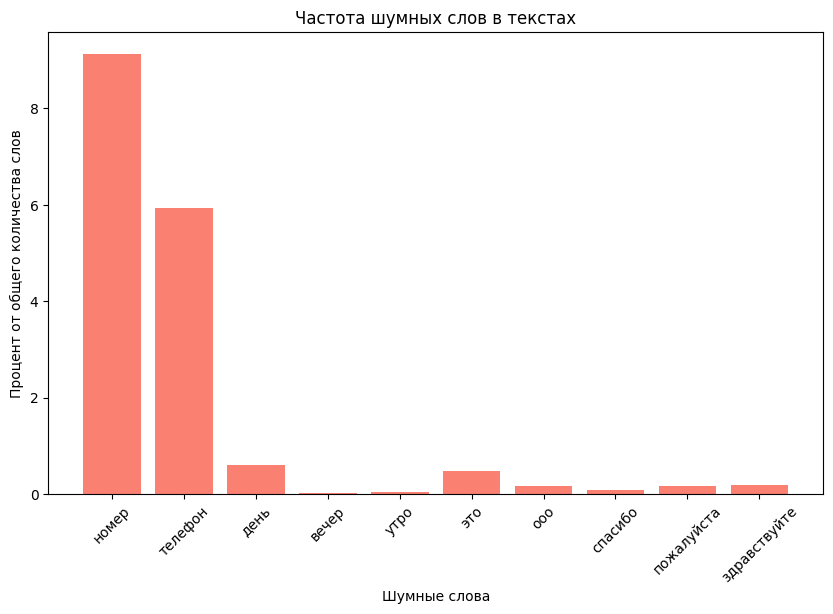

Частоты шумных слов и их % от общего количества слов:
номер: 41552 раз, 9.13% от общего количества слов
телефон: 26982 раз, 5.93% от общего количества слов
день: 2768 раз, 0.61% от общего количества слов
вечер: 72 раз, 0.02% от общего количества слов
утро: 184 раз, 0.04% от общего количества слов
это: 2146 раз, 0.47% от общего количества слов
ооо: 719 раз, 0.16% от общего количества слов
спасибо: 382 раз, 0.08% от общего количества слов
пожалуйста: 738 раз, 0.16% от общего количества слов
здравствуйте: 862 раз, 0.19% от общего количества слов


In [134]:
all_words = [word for words in df['descr_keys'] for word in words]
word_counts = Counter(all_words)

noisy_word_counts = {word: word_counts[word] 
                     for word in ['номер', 'телефон', 'день', 'вечер', 'утро', 'это', 'ооо', 'спасибо', 'пожалуйста', 'здравствуйте']}

perc = {word: (count / sum(word_counts.values())) * 100 for word, count in noisy_word_counts.items()}


plt.figure(figsize=(10, 6))
plt.bar(perc.keys(), perc.values(), color='salmon')
plt.xlabel('Шумные слова')
plt.ylabel('Процент от общего количества слов')
plt.title('Частота шумных слов в текстах')
plt.xticks(rotation=45)
plt.show()

# Выводим частоты в виде текста для анализа
print("Частоты шумных слов и их % от общего количества слов:")
for word, count in noisy_word_counts.items():
    print(f"{word}: {count} раз, {perc[word]:.2f}% от общего количества слов")

In [104]:
def remove_stopwords(word_list):
    return [word for word in word_list if word not in stopwords_set]

df['cleaned_words'] = df['descr_keys'].apply(remove_stopwords)

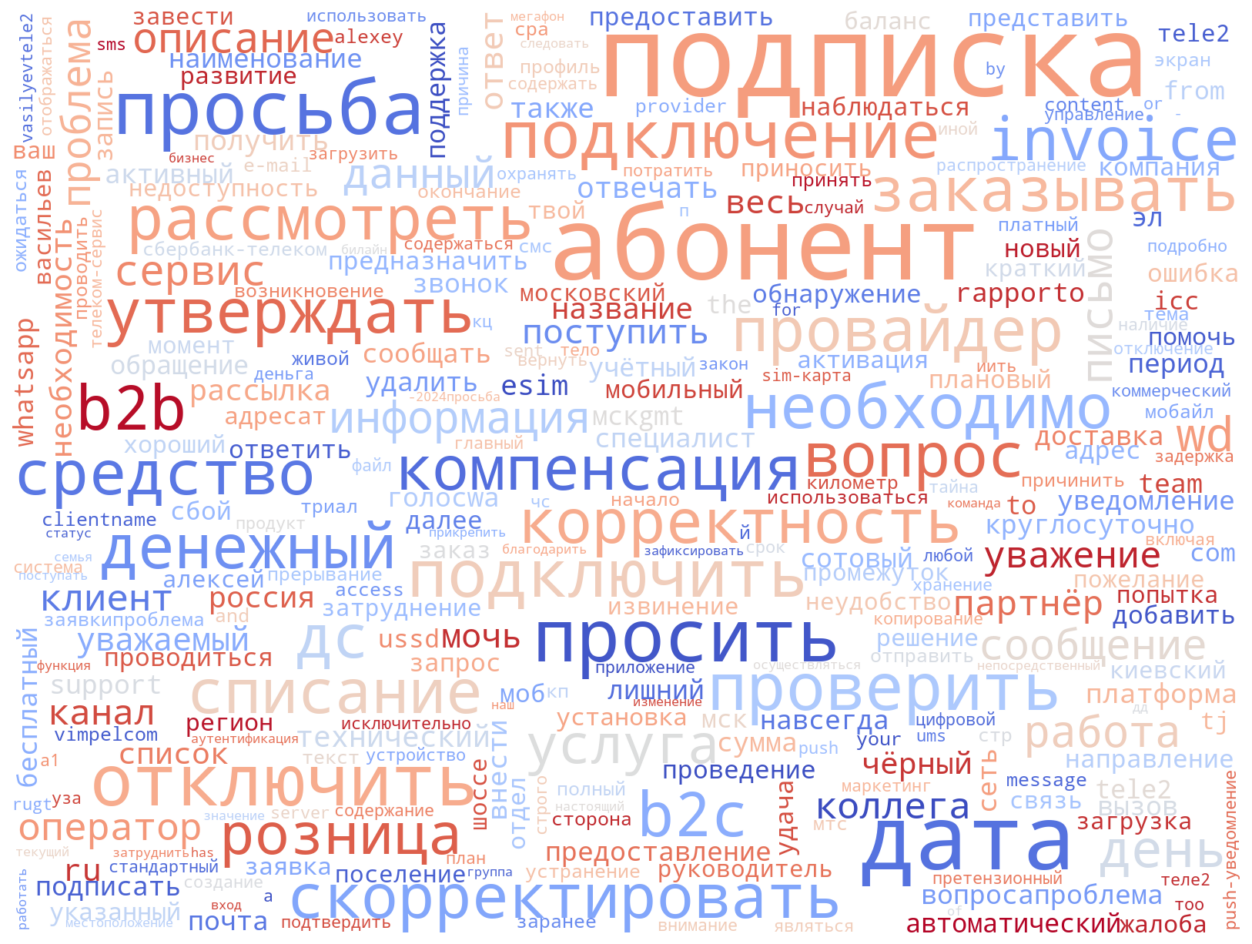

In [61]:
cloud = WordCloud(
    width=1600,
    height=1200,
    max_font_size=150,
    min_font_size=10,
    max_words=300,
    background_color='white',
    colormap="coolwarm",
    contour_color='black',
    relative_scaling=0.5,
    random_state=42
).generate_from_frequencies(cl_descr_keys)

plt.figure(figsize=(16, 12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [98]:
from collections import Counter

def lat_words(lst):
    return [word for word in lst if re.match(r'^[A-Za-z]+$', word)]

latin_words_ser = df['descr_keys'].apply(lat_words)
latin_words = [word for sublist in latin_words_ser for word in sublist]
latin_word_counts = Counter(latin_words)

for word, count in latin_word_counts.most_common(20):
    print(f"{word}: {count} раз(а)")

invoice: 3739 раз(а)
wd: 2291 раз(а)
ru: 1005 раз(а)
esim: 807 раз(а)
whatsapp: 629 раз(а)
support: 625 раз(а)
team: 595 раз(а)
rapporto: 587 раз(а)
to: 500 раз(а)
icc: 468 раз(а)
com: 447 раз(а)
the: 447 раз(а)
ussd: 406 раз(а)
from: 401 раз(а)
tj: 338 раз(а)
content: 283 раз(а)
clientname: 281 раз(а)
your: 277 раз(а)
and: 269 раз(а)
access: 267 раз(а)


In [106]:
replacement_dict = {
    'provider': 'провайдер',
    'esim': 'есим',
    'b2b': 'б2б',
    'b2c': 'б2с',
    'invoice': 'инвойс',
    'tele2': 'теле2',
    'mts': 'мтс',
    'sim': 'сим',
    'sim-карта': 'сим-карта',
    'server': 'сервер',
    'sms': 'смс',
    'vimpelcom': 'вымпелком',
    'whatsapp': 'ватсапп',
    'message': 'сообщение',
    'access': 'доступ',
    'team': 'команда',
    'systems': 'система',
    'delivery': 'доставка',
    'diagnostic': 'диагностика',
    'information': 'информация',
    'help': 'помощь',
    'wd': 'вд',
    'ru': 'ру',
    'mobile': 'мобильный',
    'mailbox': 'мэилбокс',
    'sim-меню': 'сим-меню',
    'id': 'айди',
    'snminakovabeeline': 'билайн',
    'beeline': 'билайн',
    'iphone': 'айфон',
    'gprs': 'грпс',
    'ltmobidsupportmts': 'мтс',
    'team': 'команда',
    '-2024просьба': 'просьба',
    'эл': 'электронный'
}

def process_words(words):
    return [replacement_dict.get(word.lower(), word.lower()) for word in words
            if not (word == '-' or re.match(r'^[A-Za-z0-9-]+$', word)) or word.lower() in replacement_dict]


df['cleaned_words_ru'] = df['cleaned_words'].apply(process_words)

------
Попробуем очистить текст от ФИО
-

In [111]:
df[['descr', 'cleaned_words_ru']].loc[133]

descr               Коллеги, добрый день! Прошу внести изменения: Прошу изменить учётную запись для билайн ЛК B2B - "client_id":"BeelineB2BMobileID-Tele2". Новый jwks_url - https://static.beeline.ru/upload/MobileID/images/config/B2B-Box.json == С наилучшими пожеланиями, Алексей Васильев Руководитель направления по развитию сервисов и платформ. Tele2 Россия 108811, поселение Московский, Киевское шоссе, 22-й километр, д. 6, стр. 1 Моб. &amp;#43...
cleaned_words_ru                                                                                                                         [коллега, ., просить, внести, изменение, просить, изменить, учётный, запись, билайн, лк, б2б, ., новый, ., билайн, ., ., хороший, пожелание, алексей, васильев, руководитель, направление, развитие, сервис, платформа, ., теле2, россия, поселение, московский, киевский, шоссе, километр, далее, ., стр, ., моб, ., .]
Name: 133, dtype: object

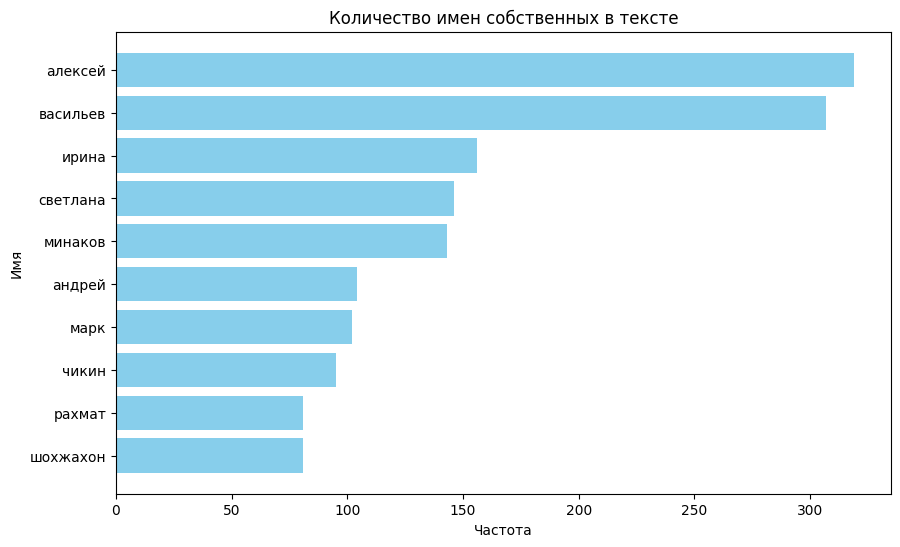

In [130]:
morph = pymorphy3.MorphAnalyzer()

def collect_all_names(df_column):
    all_names = []
    for words in df_column:
        for word in words:
            parsed = morph.parse(word)[0]
            if any(tag in parsed.tag for tag in ('Name', 'Surn', 'Patr')):
                all_names.append(parsed.normal_form) 
    return all_names

all_names = collect_all_names(df['cleaned_words_ru'])
name_counts = Counter(all_names)

most_common_names = name_counts.most_common(10)
names, counts = zip(*most_common_names)

plt.figure(figsize=(10, 6))
plt.barh(names, counts, color='skyblue')
plt.xlabel('Частота')
plt.ylabel('Имя')
plt.title('Количество имен собственных в тексте')
plt.gca().invert_yaxis()
plt.show()

In [113]:
def remove_names(words):
    result = []
    for word in words:
        parsed = morph.parse(word)[0]
        if any(tag in parsed.tag for tag in ('Name', 'Surn', 'Patr')):
            continue  
        result.append(word)
    
    return result

df['cleaned_words_ru_f'] = df['cleaned_words_ru'].apply(remove_names)

In [114]:
df[['descr', 'cleaned_words_ru_f']].loc[133]

descr                 Коллеги, добрый день! Прошу внести изменения: Прошу изменить учётную запись для билайн ЛК B2B - "client_id":"BeelineB2BMobileID-Tele2". Новый jwks_url - https://static.beeline.ru/upload/MobileID/images/config/B2B-Box.json == С наилучшими пожеланиями, Алексей Васильев Руководитель направления по развитию сервисов и платформ. Tele2 Россия 108811, поселение Московский, Киевское шоссе, 22-й километр, д. 6, стр. 1 Моб. &amp;#43...
cleaned_words_ru_f                                                                                                                                            [коллега, ., просить, внести, изменение, просить, изменить, учётный, запись, билайн, лк, б2б, ., новый, ., билайн, ., ., хороший, пожелание, руководитель, направление, развитие, сервис, платформа, ., теле2, россия, поселение, московский, киевский, шоссе, километр, далее, ., стр, ., моб, ., .]
Name: 133, dtype: object

## Очистка других текстовых полей

In [115]:
df['sender_name'].value_counts().to_frame().head(20)

,count
sender_name,
content_problem,4648
Система Отчётности Смартер,689
service_cp,639
Rapporto Support,599
NOC Sberbank-Telecom,281
HelpDesk Info,258
mobileid@tele2.ru,250
no-reply,170
Svetlana N Minakova,142


In [116]:
df['sender_name_cut'] = df['sender_name'].where(df['sender_name'].isin(['content_problem', 'Система Отчётности Смартер', 'service_cp',
                                                  'Rapporto Support', 'NOC Sberbank-Telecom', 'HelpDesk Info',
                                                  'mobileid@tele2.ru', 'no-reply', 'postmaster', 'MobIDsupport',
                                                                        'Help-And-Support-Partner'
                                                  ]))

In [118]:
df['theme'].unique().tolist()[:15]

['Жалоба абонента  TT20595877',
 'Жалоба абонента  TT20592639',
 'Жалоба абонента  TT20594559',
 'Жалоба абонента  TT20593507',
 'Жалоба абонента  TT20593899',
 'Re: [Ticket#10276498] Уведомление.Сбой на стороне оператора Теле2-Казахстан (01.01.23 14:19-15:03)',
 'ЧС по 99993 от 01.01.2023',
 'Жалоба абонента  TT20595548',
 'Жалоба абонента  TT20598328',
 'Жалоба абонента  TT20591891',
 'отключение',
 'Жалоба TT20600601',
 'ЧС по 99993 от 02.01.2023',
 'Undeliverable: A1S: Политика обновления вашего пароля',
 'Жалоба абонента  TT20604112']

In [119]:
def process_text(text):
    text = re.sub(r'\s*TT\d{8}', '', text)

    for eng_word, rus_word in replacement_dict.items():
        text = text.replace(eng_word.lower(), rus_word)
    if 'ЧС' in text:
        return ['черный список']
    if 'зарегистрировано обращение' in text.lower():
      return ['регистрация обращения']

    text = re.sub(r'[A-Za-z]', '', text)
    text = re.sub(r'[^\w\s-]', ' ', text)
    words = text.lower().split()

    return [morph.parse(word)[0].normal_form for word in words if re.search(r'[а-яёa-z]', word)]

df['processed_theme'] = df['theme'].apply(process_text)

df[['theme', 'processed_theme']].head(20)

,theme,processed_theme
0,Жалоба абонента TT20595877,"[жалоба, абонент]"
1,Жалоба абонента TT20592639,"[жалоба, абонент]"
2,Жалоба абонента TT20594559,"[жалоба, абонент]"
3,Жалоба абонента TT20593507,"[жалоба, абонент]"
4,Жалоба абонента TT20593899,"[жалоба, абонент]"
5,Re: [Ticket#10276498] Уведомление.Сбой на стороне оператора Теле2-Казахстан (01.01.23 14:19-15:03),"[уведомление, сбой, на, сторона, оператор, теле2-казахстан]"
6,ЧС по 99993 от 01.01.2023,[черный список]
7,Жалоба абонента TT20595548,"[жалоба, абонент]"
8,Жалоба абонента TT20598328,"[жалоба, абонент]"
9,Жалоба абонента TT20591891,"[жалоба, абонент]"


In [122]:
df['cleaned_column'] = df['cleaned_words_ru_f'].apply(
    lambda lst: [item for i, item in enumerate(lst) if item != '.' or (i > 0 and lst[i-1] != '.')]
).apply(lambda lst: lst[1:] if lst and lst[0] == '.' else lst)

df['texts_cmb'] = df.apply(lambda x: ' . '.join([' '.join(x['processed_theme']), ' '.join(x['cleaned_column'])]), axis=1)

In [126]:
df_prep = df[['start_dt',	'end_dt',	'sender_name',	'sender_email',	'theme','descr',
              'sender_name_cut', 'texts_cmb']]

In [135]:
df_prep.to_csv('tickets_processed_llm.csv')